# Portfolio Workflow

In [28]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)
import utils
importlib.reload(utils)
import nonoverlapping_estimator as ai_estimator
importlib.reload(ai_estimator)

print(f'Python version: {python_version()}')
print(f'Pandas version: {pd.__version__}')
print()

Sci-Kit version: 0.24.1
Python version: 3.8.8
Pandas version: 1.2.4



In [2]:
# For Chromedriver
from pathlib import Path
chrome_executabel_path = str(Path.home()) + r'\Anaconda Projects\chromedriver\chromedriver'

# Make sure we have a data directory
Path('./data').mkdir(parents=True, exist_ok=True) 

# Which account are we interested in
masked_account_number = '#---9216'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories.csv'

username, password, client_id = amc.configure_ameritrade('maiotradeuser', 'maiotradepw', 'maiotradeclientid')

# Stage 1: Generate Stock Universe

- Gather stocks from specific criteria (SP500 top 50...)
- Use stock sentiment to select stocks
- Gather price histories

## Stock Universe

Here we setup the univers. This needs some work. The long term goal is to use a pipeline process to help select stock that are in the top 500 or something similare.

For now we will use stocks from the portfolio, but stocks of interest (high news items), a list of well known stocks (this also has been augmented with some stocks that made Ameritrade's top 10 movers for a couple of days. This Ameritrade funciton has not been coded yet, but should be add down the line to automate pulling these tickers.

# Price History data

In [22]:
number_of_years = 3
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories:         {price_histories.date.min().date()} to {price_histories.date.max().date()}')
latest_date = price_histories.date.max() 
earliest_date = latest_date - pd.DateOffset(years=number_of_years)
price_histories = price_histories[(price_histories.date >= earliest_date) & (price_histories.date <= latest_date)]
print(f'Working date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
close = utils.get_close_values(price_histories)
print(f'Date range for working close prices:    {close.index.min().date()} to {close.index.max().date()}')
print(f'You have {len(close.columns)} stocks')

Date range for price histories:         2017-01-03 to 2022-01-03
Working date range for price histories: 2019-01-03 to 2022-01-03
Date range for working close prices:    2019-01-03 to 2022-01-03
You have 452 stocks


# Stage 2a: Generate Alpha Factors using Stock Universe

- Compute custom apha factors
- Compute univeral quant factors
- Compute date information
- Save Alpha Factors

In [23]:
snp_500_stocks = utils.get_snp500()
sector_helper = utils.get_sector_helper(snp_500_stocks, 'GICS Sector', close.columns)
all_factors = pd.concat(
[
    # alpha_factors.FactorMomentum(price_histories, 120).demean(groupby=sector_helper.values()).rank().zscore().for_al(),
    alpha_factors.OvernightSentiment(price_histories, 5).rank().zscore().smoothed(10).rank().zscore().for_al(),
    alpha_factors.FactorMeanReversion(price_histories, 5).demean(groupby=sector_helper.values()).rank().zscore().for_al(),
    alpha_factors.AnnualizedVolatility(price_histories, 20).rank().zscore().for_al()
], axis=1)
all_factors.sort_index(inplace=True)
all_factors = all_factors.dropna()

all_factors.to_csv('data/all_factors.csv')

# Stage 2b: Generate AI Alpha Factors

- Compute target values (y)
    - Quantize with 2 bins
- Train model for Feature importance
- Feature reduction
- Train model for AI Alpha Vector
- Compute AI Alpha Vectors for 1 year
- Save AI Alpha Vectors

## Compute the target values (y) and Shift back to create a 5 day forward prediciton

This is something you want to experiment with. If you are planning on holding on to assets for long periods of time, perhaps a 20, 40 or 60 forward prediciton will work better.

In [24]:
prod_target_source = '5Day2Quant'
prod_target_quantiles = 2
forward_prediciton_days = 5

all_assets = all_factors.index.levels[1].values.tolist()
print(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')
features = all_factors.columns.tolist()

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, prod_target_quantiles, forward_prediciton_days).for_al(prod_target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)

all_factors['target'] = all_factors.groupby(level='ticker')[prod_target_source].shift(-forward_prediciton_days)

Factors from date: 2019-01-10 00:00:00+00:00 to date: 2022-01-03 00:00:00+00:00


In [25]:
n_days = 10
n_stocks = len(set(all_factors.index.get_level_values(level='ticker').values))
clf_random_state = 42

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_days * n_stocks,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 1000]

In [26]:
from sklearn.ensemble import RandomForestClassifier

temp = all_factors.dropna().copy()
X = temp[features]
y = temp['target']

clf = RandomForestClassifier(1000, **clf_parameters)

clf_nov = ai_estimator.NoOverlapVoter(clf, n_skip_samples=forward_prediciton_days-1)
clf_nov.fit(X, y)

print(f'train: {clf_nov.score(X, y.values)} oob: {clf_nov.oob_score_}')

train: 0.5121914135709764 oob: 0.5096297663448356


Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          2.06
mean_reversion_5_day_logret                

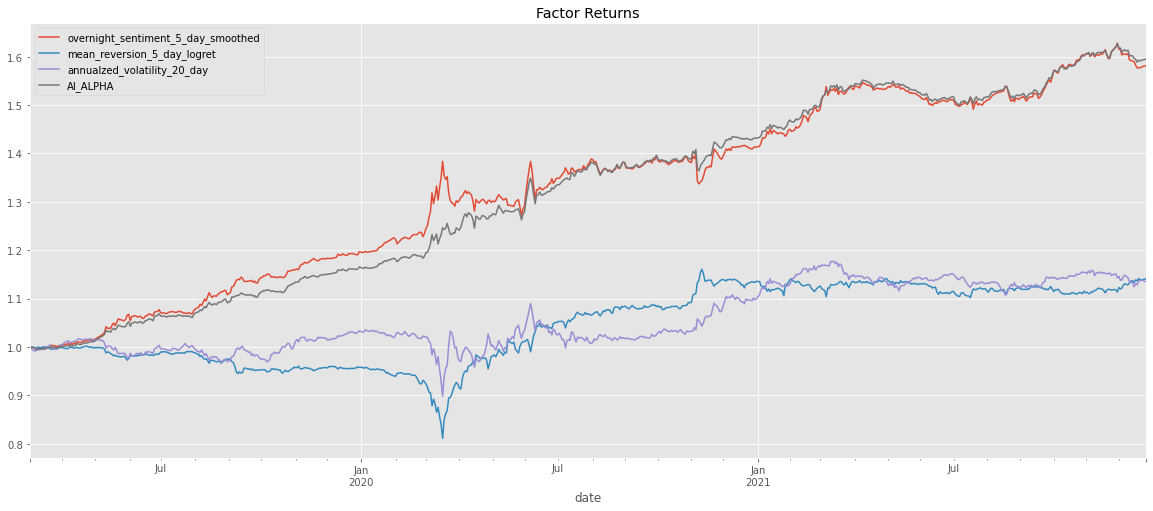

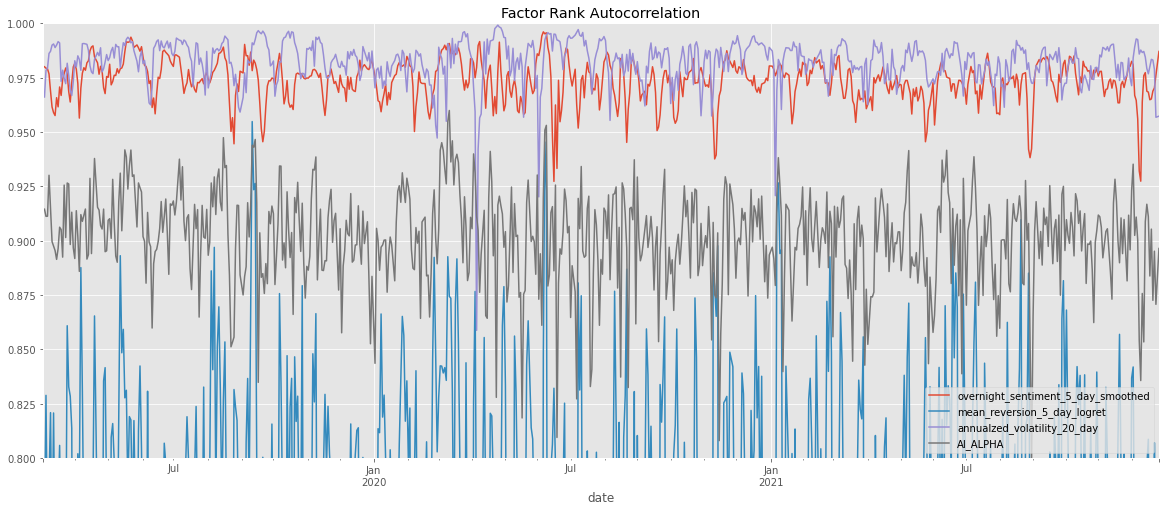

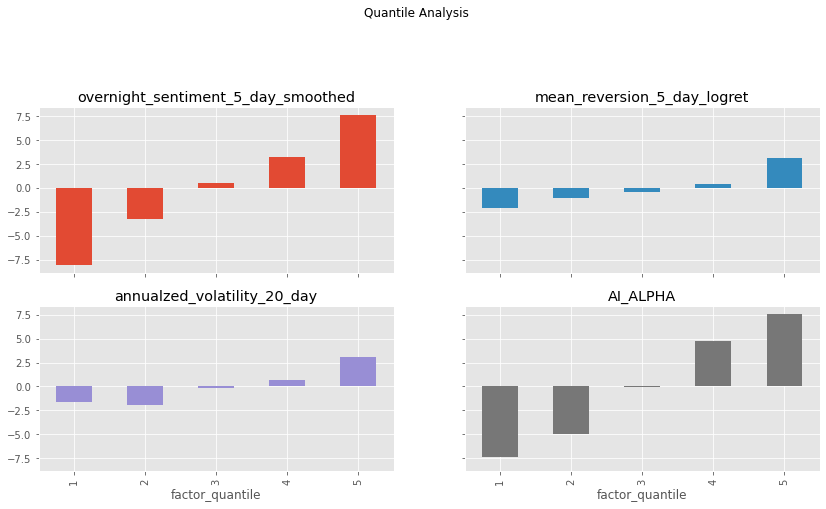

In [29]:
alpha_factors.evaluate_ai_alpha(all_factors, X, clf_nov, features, close)

In [30]:
all_factors.index.names.index('date')

0

In [31]:
all_factors.index.levels[0]

DatetimeIndex(['2019-01-10 00:00:00+00:00', '2019-01-11 00:00:00+00:00',
               '2019-01-14 00:00:00+00:00', '2019-01-15 00:00:00+00:00',
               '2019-01-16 00:00:00+00:00', '2019-01-17 00:00:00+00:00',
               '2019-01-18 00:00:00+00:00', '2019-01-22 00:00:00+00:00',
               '2019-01-23 00:00:00+00:00', '2019-01-24 00:00:00+00:00',
               ...
               '2021-12-20 00:00:00+00:00', '2021-12-21 00:00:00+00:00',
               '2021-12-22 00:00:00+00:00', '2021-12-23 00:00:00+00:00',
               '2021-12-27 00:00:00+00:00', '2021-12-28 00:00:00+00:00',
               '2021-12-29 00:00:00+00:00', '2021-12-30 00:00:00+00:00',
               '2021-12-31 00:00:00+00:00', '2022-01-03 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=752, freq='C')

In [32]:
alpha_scores = alpha_factors.compute_ai_alpha_score(all_factors[features], clf_nov)

In [33]:
ai_alpha = pd.DataFrame(alpha_scores, index=all_factors.index, columns=['AI_ALPHA']).reset_index()
ai_alpha['date'] = ai_alpha['date'].dt.date
alpha_vectors = ai_alpha.reset_index().pivot(index='date', columns='ticker', values='AI_ALPHA')
alpha_vectors.reset_index().to_csv('data/alpha_vectors.csv', index=False)

# Stage 3: Generate Beta Factors

- Use Risk Model
- Compute Daily Betas for 1 year

In [34]:
returns = alpha_factors.FactorReturns(price_histories).factor_data
end_date = returns.index.max()
start_date = end_date - pd.offsets.DateOffset(years=1)
print(f'Generating 1 year Betas from {start_date} to {end_date}')
beta_dates = pd.date_range(start_date, end_date, freq='D')
daily_betas = {}
for beta_date in returns[start_date:].index:
    start_of_returns = beta_date - pd.offsets.DateOffset(years=1) + pd.offsets.DateOffset(days=1) 
    beta_returns = returns.loc[start_of_returns:beta_date]
    risk_model = alpha_factors.RiskModelPCA(beta_returns, 1, 20)
    daily_betas[beta_date.strftime('%m/%d/%Y')] = risk_model

Generating 1 year Betas from 2021-01-03 00:00:00+00:00 to 2022-01-03 00:00:00+00:00


In [35]:
with open('data/daily_beta.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(daily_betas, f, pickle.HIGHEST_PROTOCOL)

# Stage 4a: Demonstrate using AI Alpha and Daily Betas to produce optiomal weights

In [36]:
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks from picing')

alpha_vectors = pd.read_csv('data/alpha_vectors.csv', parse_dates=['date']).set_index(['date']).sort_index()
print(f'You have {len(alpha_vectors.columns)} stocks from alpha')

with open('data/daily_beta.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
print(f'You have {len(daily_betas)} of daily betas')

Date range for price histories: 2017-01-03 to 2022-01-03
You have 452 stocks from picing
You have 452 stocks from alpha
You have 253 of daily betas


## Generate Daily Optimal Portfolios using 1 year of alpha and beta

This first strategy is to use 2 day returns and optimize the portfolio daily.

The second stragety is to use last day of the month returns and to optimize the portfolio monthly (or 20 day returns).

Start with the last date, subtract 1 year to get the start and end dates for the betas.

In [37]:
import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

risk_cap = 0.15
weights_max = 0.25
weights_min = 0.00

## 5 Day Strategy Backtest

Use 5 Day returns and optimize portfolio weekly. 

We are looking for something at 8% return or better

In [38]:
returns = alpha_factors.FactorReturns(price_histories).factor_data
dlyreturn_n_days_delay = 5
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
init_port_value = portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list()[-252::dlyreturn_n_days_delay], desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings

Generating 1 year Optimal Portfolios from 2021-01-05 00:00:00+00:00 to 2021-12-27 00:00:00+00:00


Dates:   0%|          | 0/50 [00:00<?, ?Portfolio Optimization/s]

C:\Users\HP-Z440\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:1124: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return self._get_label(key, axis=axis)
C:\Users\HP-Z440\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:1124: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return self._get_label(key, axis=axis)
C:\Users\HP-Z440\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexing.py:1124: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return self._get_label(key, axis=axis)
C:\Users\HP-Z440\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexi

<>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-39-352ff8196de1>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(False, f'Backtest indicates this strategy needs more work! ({port_return})')


Starting portfolio: 100000 Ending portfolio: 107823.98408057424 Return: 7.53%
Backtest indicates this strategy needs more work! (7.53)


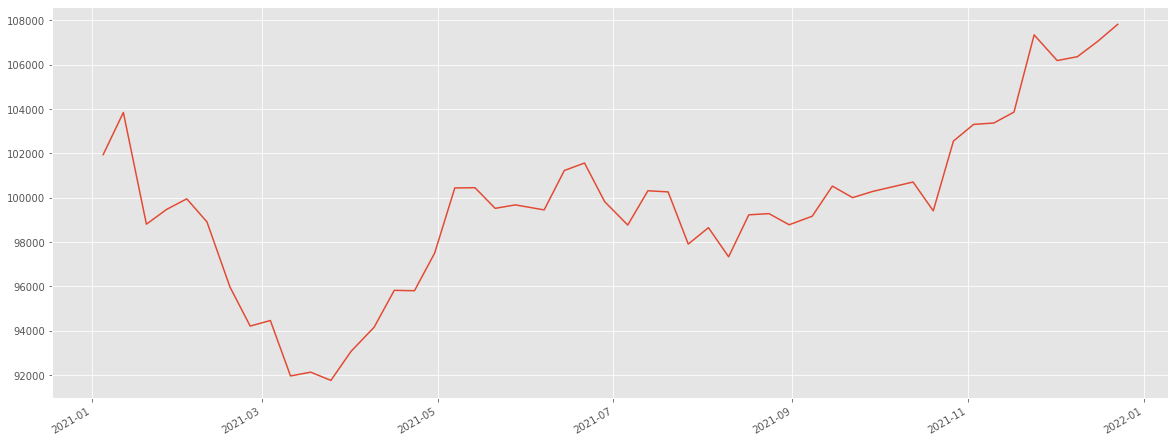

In [39]:
pd.Series(portfolio_growth).plot()
port_return = round(np.log(portfolio_value / init_port_value) * 100, 2)
print(f'Starting portfolio: {init_port_value} Ending portfolio: {portfolio_value} Return: {port_return}%')
if port_return >= 8:
    print('Backtest indicates its okay to proceed with this strategy.')
else:
    print(f'Backtest indicates this strategy needs more work! ({port_return})')
    assert(False, f'Backtest indicates this strategy needs more work! ({port_return})')

<AxesSubplot:>

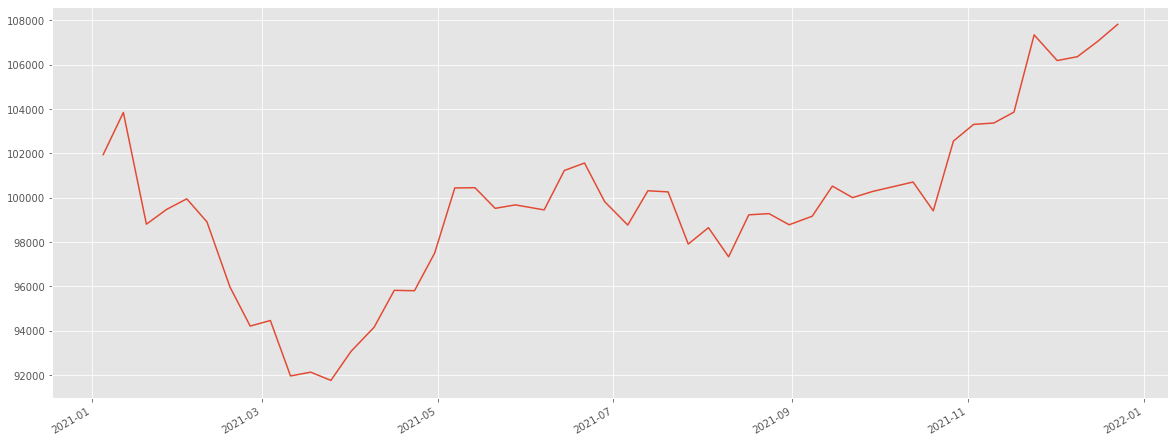

In [40]:
pd.Series(portfolio_growth).plot()

## Use the last week to determine current portfolio mix

In [41]:
opt_date = alpha_vectors.index[-1]
print(f'From date: {opt_date}')
risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

From date: 2022-01-03 00:00:00


New portfolio variance is:  0.00991923


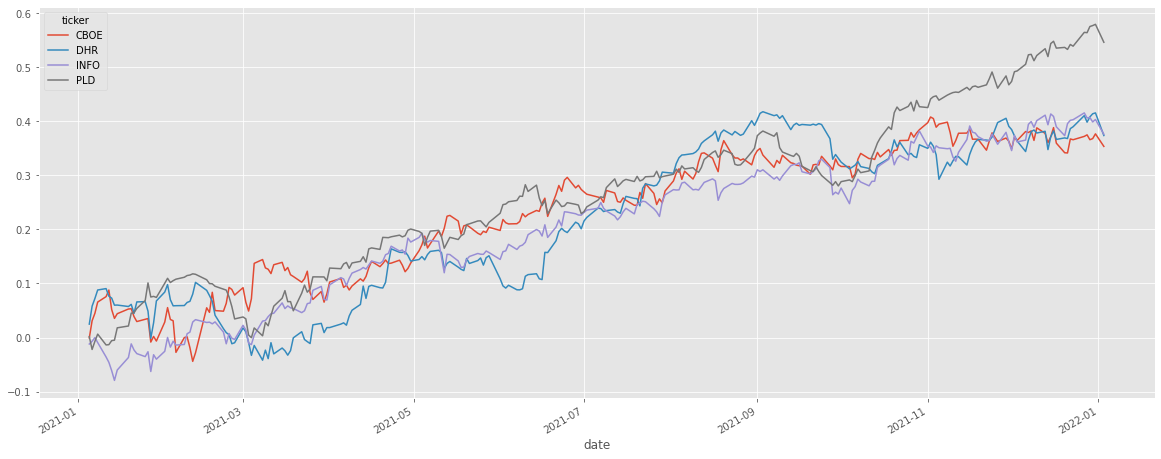

In [42]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot()
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [43]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id, chrome_executabel_path)
td_ameritrade.authenticate()
td_ameritrade.get_fundamental(list(long_weights.index.to_list()))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,74340W103,PLD,"Prologis, Inc. Common Stock",NYSE,EQUITY,169.9300,93.08,2.52,1.50,2021-12-13 00:00:00.000,...,9.10794,0.0,0.0,0.0,0.63,2021-12-31 00:00:00.000,0.82492,2485620.0,2485621.0,47838290.0
1,12503M108,CBOE,"Cboe Global Markets, Inc. Common Stock",BATS,EQUITY,138.9994,87.00,1.92,1.47,2021-11-29 00:00:00.000,...,58.70955,0.0,0.0,0.0,0.48,2021-12-15 00:00:00.000,0.18259,903670.0,409388.0,19068560.0
2,G47567105,INFO,IHS Markit Ltd. Common Shares,NYSE,EQUITY,135.8200,83.26,0.80,0.60,2021-10-28 00:00:00.000,...,18.61226,0.0,0.0,0.0,0.20,2021-11-12 00:00:00.000,1.00699,2090410.0,2090405.0,46257020.0
3,235851102,DHR,Danaher Corporation Common Stock,NYSE,EQUITY,333.9600,211.22,0.84,0.26,2021-12-29 00:00:00.000,...,10.14896,0.0,0.0,0.0,0.21,2022-01-28 00:00:00.000,0.70357,2319060.0,2319059.0,51627300.0


Tickers:   0%|          | 0/4 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/4 [00:00<?, ?News Table Items/s]

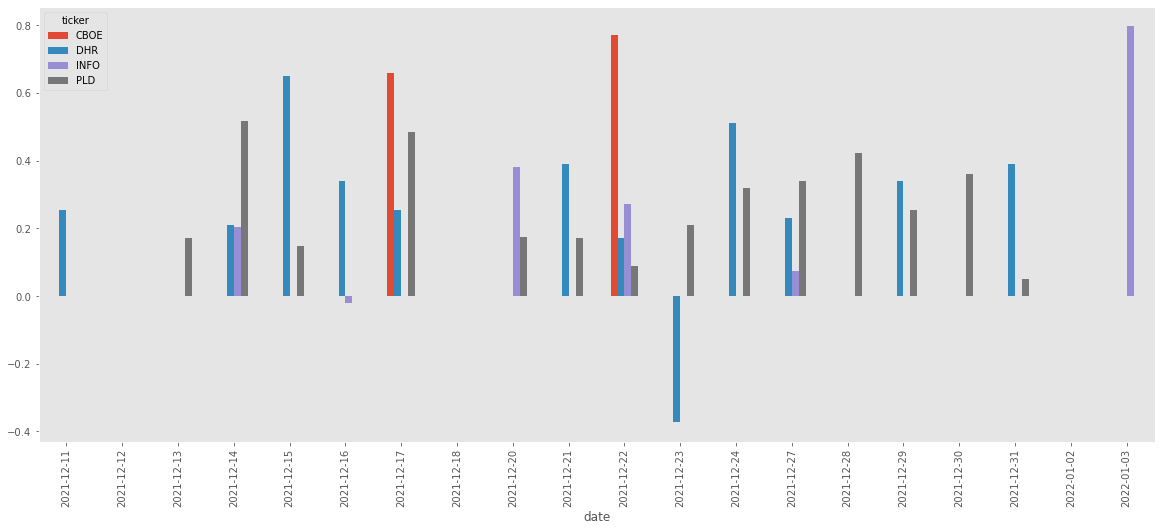

In [44]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [45]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id, chrome_executabel_path)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

print(f'Date of trade: {datetime.today()}')

# Specific Portfolio Account
account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
print('Full Equity Portfolio:')
display(equity_investments_df)

long_term_stocks =  ['FGPHF', 'WKHS', 'EEENF']

# Filter out non Equity investments
current_stocks = amc.AmeritradeRest(username, password, client_id).get_quotes(utils.get_investment_symbols(equity_investments_df)).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[~equity_investments_df['symbol'].isin(long_term_stocks)]
print('Stocks to sell:')
stocks_to_sell

You have authorization
Date of trade: 2022-01-03 14:39:21.232970
Full Equity Portfolio:


,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
9,#---9216,0.0,384.81000,0.0,-3.75000,-0.23,5.000,5.0,0.0,1657.70,497.31,5.000,EQUITY,911363109,URI,0,0
10,#---9216,0.0,164.74612,0.0,-2.32369,-0.14,10.103,10.0,0.0,1611.83,483.55,10.103,EQUITY,828806109,SPG,0,0
11,#---9216,0.0,45.82500,0.0,19.50000,1.45,30.000,30.0,0.0,1365.90,409.77,30.000,EQUITY,552953101,MGM,0,0
12,#---9216,0.0,0.21397,0.0,24.37500,3.24,5000.000,5000.0,0.0,775.63,0.00,5000.000,EQUITY,Q3860H107,FGPHF,0,0


Stocks to sell:


,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
9,#---9216,0.0,384.81000,0.0,-3.75000,-0.23,5.000,5.0,0.0,1657.70,497.31,5.000,EQUITY,911363109,URI,0,0
10,#---9216,0.0,164.74612,0.0,-2.32369,-0.14,10.103,10.0,0.0,1611.83,483.55,10.103,EQUITY,828806109,SPG,0,0
11,#---9216,0.0,45.82500,0.0,19.50000,1.45,30.000,30.0,0.0,1365.90,409.77,30.000,EQUITY,552953101,MGM,0,0


### Submit and montior sell orders

In [46]:
account_number = td_ameritrade.unmasked_accounts[masked_account_number]
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

Placing SELL order on #---9216 for 5.0 shares of URI...
Placed SELL order on #---9216 for 5.0 shares of URI
Placing SELL order on #---9216 for 10.103 shares of SPG...
Placed SELL order on #---9216 for 10.103 shares of SPG
Placing SELL order on #---9216 for 30.0 shares of MGM...
Placed SELL order on #---9216 for 30.0 shares of MGM


In [53]:
while True:
    td_ameritrade = amc.AmeritradeRest(username, password, client_id, chrome_executabel_path)
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[~equity_investments_df['symbol'].isin(long_term_stocks)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    print(f'\r{datetime.today()} - Stocks to sell: {stocks_with_sell_orders.symbol.values}', end='           ')
    time.sleep(60)
    
print(f'\r{datetime.today()} - All stocks sold: {stocks_to_sell.symbol.values}')

2022-01-03 15:14:27.723793 - All stocks sold: ['URI' 'SPG' 'MGM']


In [54]:
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
print(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
print(f'Total cash to invest: {available_cash}')

initialBalances_cashBalance           0.000000
initialBalances_totalCash             0.000000
initialBalances_equity             5468.230000
initialBalances_moneyMarketFund     846.220000
currentBalances_cashBalance        4612.150000
currentBalances_equity             5491.310000
currentBalances_moneyMarketFund     862.720000
current_return                        0.004212
Name: #---9216, dtype: float64
4612.15
862.72
Total cash to invest: 5474.87


In [55]:
print(f'Available cash  : {available_cash}')
investment_base = 500
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 5474.87
Amount to invest: 5000


In [60]:
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
long_quotes = amc.AmeritradeRest(username, password, client_id).get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['invest_amount'] = (long_weights['optimalWeights'] * investment_amount).round(0)
long_shares['est_shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice'])
long_shares['shares'] = nearest_base * round(long_shares['est_shares'] / nearest_base)
long_shares['cost'] = long_shares['shares'] * long_shares['regularMarketLastPrice']
print(f'Total cost: {long_shares.cost.sum()}')
long_shares

Initial investment amount: 5000
Total cost: 5781.0


,regularMarketLastPrice,invest_amount,est_shares,shares,cost
CBOE,127.85,1250.0,9.777083,10.0,1278.5
DHR,312.80,1250.0,3.996164,5.0,1564.0
INFO,130.04,1250.0,9.612427,10.0,1300.4
PLD,163.81,1250.0,7.630792,10.0,1638.1


### Place buy orders

In [61]:
print(datetime.today())
long_quotes = amc.AmeritradeRest(username, password, client_id).get_quotes(long_weights.index.to_list())
long_shares['current_price'] = long_quotes['regularMarketLastPrice']
long_shares['actual_cost'] = long_shares.cost
long_shares['current_amount'] = long_shares.shares * long_shares['current_price']
long_shares['profit/loss'] = long_shares.current_amount - long_shares.actual_cost
long_shares['returns'] = utils.compute_log_returns_days(long_shares.cost, long_shares.current_price) 
display(long_shares)

2022-01-03 15:21:38.702181


,regularMarketLastPrice,invest_amount,est_shares,shares,cost,current_price,actual_cost,current_amount,profit/loss,returns
CBOE,127.85,1250.0,9.777083,10.0,1278.5,127.76,1278.5,1277.60,-0.90,-2.303289
DHR,312.80,1250.0,3.996164,5.0,1564.0,312.91,1564.0,1564.55,0.55,-1.609086
INFO,130.04,1250.0,9.612427,10.0,1300.4,129.95,1300.4,1299.50,-0.90,-2.303277
PLD,163.81,1250.0,7.630792,10.0,1638.1,163.91,1638.1,1639.10,1.00,-2.301975


In [62]:
td_ameritrade.get_fundamental(list(long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,74340W103,PLD,"Prologis, Inc. Common Stock",NYSE,EQUITY,169.9300,93.08,2.52,1.50,2021-12-13 00:00:00.000,...,9.10794,0.0,0.0,0.0,0.63,2021-12-31 00:00:00.000,0.82492,2485620.0,2485621.0,47838290.0
1,12503M108,CBOE,"Cboe Global Markets, Inc. Common Stock",BATS,EQUITY,138.9994,87.00,1.92,1.47,2021-11-29 00:00:00.000,...,58.70955,0.0,0.0,0.0,0.48,2021-12-15 00:00:00.000,0.18259,903670.0,409388.0,19068560.0
2,G47567105,INFO,IHS Markit Ltd. Common Shares,NYSE,EQUITY,135.8200,83.26,0.80,0.60,2021-10-28 00:00:00.000,...,18.61226,0.0,0.0,0.0,0.20,2021-11-12 00:00:00.000,1.00699,2090410.0,2090405.0,46257020.0
3,235851102,DHR,Danaher Corporation Common Stock,NYSE,EQUITY,333.9600,211.22,0.84,0.26,2021-12-29 00:00:00.000,...,10.14896,0.0,0.0,0.0,0.21,2022-01-28 00:00:00.000,0.70357,2319060.0,2319059.0,51627300.0


In [63]:
for index, row in long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

Placing BUY order on 755579216 for 10.0 shares of CBOE:EQUITY...
Placed BUY order on #---9216 for 10.0 shares of CBOE
Placing BUY order on 755579216 for 5.0 shares of DHR:EQUITY...
Placed BUY order on #---9216 for 5.0 shares of DHR
Placing BUY order on 755579216 for 10.0 shares of INFO:EQUITY...
Placed BUY order on #---9216 for 10.0 shares of INFO
Placing BUY order on 755579216 for 10.0 shares of PLD:EQUITY...
Placed BUY order on #---9216 for 10.0 shares of PLD


Tickers:   0%|          | 0/4 [00:00<?, ?Price Histories/s]

<AxesSubplot:xlabel='date'>

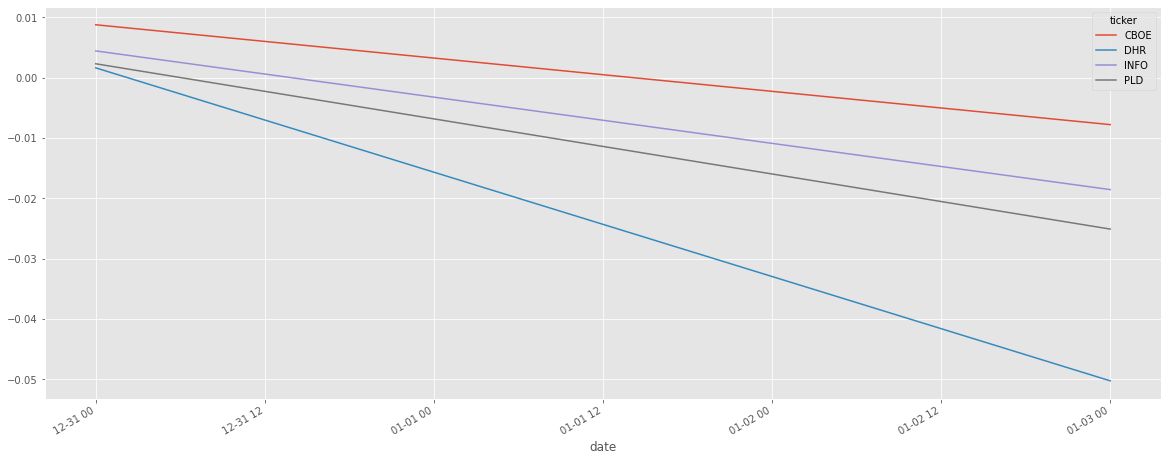

In [64]:
portfolio_price_histories = amc.AmeritradeRest(username, password, client_id).get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-2:].cumsum().plot()

In [65]:
import ameritrade_functions as amc
importlib.reload(amc)

td_ameritrade = amc.AmeritradeRest(username, password, client_id, chrome_executabel_path)
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]

initialBalances_cashBalance           0.000000
initialBalances_totalCash             0.000000
initialBalances_equity             5468.230000
initialBalances_moneyMarketFund     846.220000
currentBalances_cashBalance         389.900000
currentBalances_equity             5491.270000
currentBalances_moneyMarketFund     862.720000
current_return                        0.004205
Name: #---9216, dtype: float64